In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# loading the data
bike_ride = pd.read_csv('Bike-Sharing-Dataset/hour.csv')
bike_ride.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


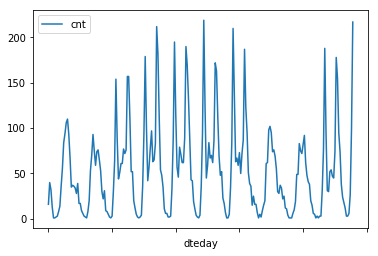

In [3]:
# plotting the data for first 10 days
bike_ride[:24*10].plot(x = 'dteday', y = 'cnt')
plt.show()

In [4]:
# Handling categorical data and cleaning data
dummy_fields = ['season', 'weathersit', 'hr', 'mnth', 'weekday']
for field in dummy_fields:
    dummies = pd.get_dummies(bike_ride[field], prefix = field, drop_first = False)
    bike_ride = pd.concat([bike_ride, dummies], axis = 1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'hr', 'workingday', 'mnth', 'atemp', 'weekday']
data = bike_ride.drop(fields_to_drop, axis = 1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,mnth_10,mnth_11,mnth_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
# scaling features
features_to_scale = ['temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
scaled_features = {}
for each_feature in features_to_scale:
    mean, std = data[each_feature].mean(), data[each_feature].std()
    scaled_features[each_feature] = [mean, std];
    data.loc[:,each_feature] = (data[each_feature]-mean)/std

In [6]:
# splitting the data into training, testing and validation set
# saving around last 21 days of data for testing
test_data = data[-21*24:]
# removing the testing data
data = data[:-21*24]

# seperating the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis = 1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis = 1), test_data[target_fields]

# saving around last 50 days of features for validation
train_features, train_targets = features[:-50*24], targets[:-50*24]
val_features, val_targets = features[-50*24:], targets[-50*24:]

In [7]:

train_features.shape

(15675, 56)

# Time to build the network

<img src="assets/neural_network.png" width=300px>

In [8]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        self.activation_function = lambda x : 1/(1+np.exp(-x))
        
    def train(self, features, targets):
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            # forward pass
            final_outputs, hidden_outputs = self.forward_pass_train(X)
            # Backproagation
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        # Hidden layer
        hidden_inputs = np.dot(X, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)

        # Output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = final_inputs 
        
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        error = (y - final_outputs)
        output_error_term = error * 1.0
        
        hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
        hidden_error_term = hidden_error * (hidden_outputs) * (1 - hidden_outputs)
        
        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:,None]
        
        # Weight step (hidden to output)
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]
        
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):

        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records

    def run(self, features):
        # Hidden layer
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)

        # Output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = final_inputs
        
        return final_outputs

In [9]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [14]:
import sys

iterations = 3000
learning_rate = 1.0
hidden_nodes = 15
output_nodes = 1

input_nodes = train_features.shape[1]
network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.loc[batch].values, train_targets.loc[batch]['cnt']                       
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.074 ... Validation loss: 0.246

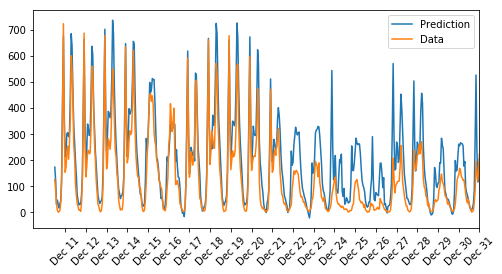

In [15]:
fig, ax = plt.subplots(figsize=(8,4))
mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(bike_ride.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)